Premier League Matchweek 25 predictions

The goal of this project is to predict the results and goals scored of Premier League matches, specifically for Matchweek 25. Using historical match data from this season, I aim to predict whether a match will result in a win, loss, or draw, as well as the number of goals each team will score.

To predict these results, we will rely on the average number of goals scored at home and away, and the goals conceded. 

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Set your API Key
API_KEY = 'xxxxxxxxxxxxxx'
BASE_URL = 'https://api.football-data.org/v4'

# Function to get Premier League data
def get_matches():
    url = f"{BASE_URL}/competitions/PL/matches"
    headers = {'X-Auth-Token': API_KEY}
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code}")
        return None

# Get data
matches_data = get_matches()


Initial Data Exploration Once we have the data, we will perform an initial exploration to better understand the structure and content.

In [82]:
# Convert data to a pandas DataFrame
matches_data_df = pd.json_normalize(matches_data['matches'])


In [83]:
# General information about the DataFrame
matches_data_df.info()

# View available columns
print(matches_data_df.columns)

# Basic statistics
matches_data_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      380 non-null    int64  
 1   utcDate                 380 non-null    object 
 2   status                  380 non-null    object 
 3   matchday                380 non-null    int64  
 4   stage                   380 non-null    object 
 5   group                   0 non-null      object 
 6   lastUpdated             380 non-null    object 
 7   referees                380 non-null    object 
 8   area.id                 380 non-null    int64  
 9   area.name               380 non-null    object 
 10  area.code               380 non-null    object 
 11  area.flag               380 non-null    object 
 12  competition.id          380 non-null    int64  
 13  competition.name        380 non-null    object 
 14  competition.code        380 non-null    ob

,id,matchday,area.id,competition.id,season.id,season.currentMatchday,homeTeam.id,awayTeam.id,score.fullTime.home,score.fullTime.away,score.halfTime.home,score.halfTime.away
count,380.000000,380.000000,380.0,380.0,380.0,380.0,380.000000,380.000000,240.000000,240.000000,240.000000,240.000000
mean,497599.500000,19.500000,2072.0,2021.0,2287.0,25.0,242.500000,242.500000,1.541667,1.495833,0.741667,0.641667
std,109.840794,10.980313,0.0,0.0,0.0,0.0,244.921435,244.921435,1.289779,1.250934,0.858098,0.889698
min,497410.000000,1.000000,2072.0,2021.0,2287.0,25.0,57.000000,57.000000,0.000000,0.000000,0.000000,0.000000
25%,497504.750000,10.000000,2072.0,2021.0,2287.0,25.0,63.750000,63.750000,1.000000,1.000000,0.000000,0.000000
50%,497599.500000,19.500000,2072.0,2021.0,2287.0,25.0,74.500000,74.500000,1.000000,1.000000,1.000000,0.000000
75%,497694.250000,29.000000,2072.0,2021.0,2287.0,25.0,351.750000,351.750000,2.000000,2.000000,1.000000,1.000000
max,497789.000000,38.000000,2072.0,2021.0,2287.0,25.0,1044.000000,1044.000000,7.000000,6.000000,4.000000,5.000000


First, we will select the most useful columns and give them shorter and clearer names.

In [84]:
# Select relevant columns
matches = matches_data_df[[
    'utcDate', 
    'homeTeam.name', 
    'awayTeam.name', 
    'score.fullTime.home', 
    'score.fullTime.away', 
    'status'
]]

# Rename columns for better clarity
matches.columns = [
    'Date', 
    'Home_Team', 
    'Away_Team', 
    'Home_Score', 
    'Away_Score', 
    'Status'
]

# Show the first rows to verify changes
matches.head()


,Date,Home_Team,Away_Team,Home_Score,Away_Score,Status
0,2024-08-16T19:00:00Z,Manchester United FC,Fulham FC,1.0,0.0,FINISHED
1,2024-08-17T11:30:00Z,Ipswich Town FC,Liverpool FC,0.0,2.0,FINISHED
2,2024-08-17T14:00:00Z,Arsenal FC,Wolverhampton Wanderers FC,2.0,0.0,FINISHED
3,2024-08-17T14:00:00Z,Everton FC,Brighton & Hove Albion FC,0.0,3.0,FINISHED
4,2024-08-17T14:00:00Z,Newcastle United FC,Southampton FC,1.0,0.0,FINISHED


Convert Data Types
Date: We will convert the date to datetime format for temporal analysis.
Scores: We will ensure that the scores are integers for statistical calculations.

In [ ]:
# Convert 'Date' to datetime format
matches['Date'] = pd.to_datetime(matches['Date'])

# Convert scores to integers
matches['Home_Score'] = pd.to_numeric(matches['Home_Score'], errors='coerce').astype('float')
matches['Away_Score'] = pd.to_numeric(matches['Away_Score'], errors='coerce').astype('float')


Filter Finished Matches
Since we want to analyze the results, we will filter only the matches that have already finished.

In [88]:
# Filter finished matches
matches_finished = matches[matches['Status'] == 'FINISHED']

# View the first rows
matches_finished.head()


,Date,Home_Team,Away_Team,Home_Score,Away_Score,Status
0,2024-08-16 19:00:00+00:00,Manchester United FC,Fulham FC,1.0,0.0,FINISHED
1,2024-08-17 11:30:00+00:00,Ipswich Town FC,Liverpool FC,0.0,2.0,FINISHED
2,2024-08-17 14:00:00+00:00,Arsenal FC,Wolverhampton Wanderers FC,2.0,0.0,FINISHED
3,2024-08-17 14:00:00+00:00,Everton FC,Brighton & Hove Albion FC,0.0,3.0,FINISHED
4,2024-08-17 14:00:00+00:00,Newcastle United FC,Southampton FC,1.0,0.0,FINISHED


Result: Indicates whether the home team won, the away team won, or it was a draw.
Total Goals: The sum of goals from both teams.

In [89]:
# Create 'Resultado' column
def calculate_result(row):
    if row['Home_Score'] > row['Away_Score']:
        return 'Home'
    elif row['Home_Score'] < row['Away_Score']:
        return 'Away'
    else:
        return 'Draw'

matches_finished['Result'] = matches_finished.apply(calculate_result, axis=1)

# Create 'Total Goals' column
matches_finished['Total_Goals'] = matches_finished['Home_Score'] + matches_finished['Away_Score']


Visualize 

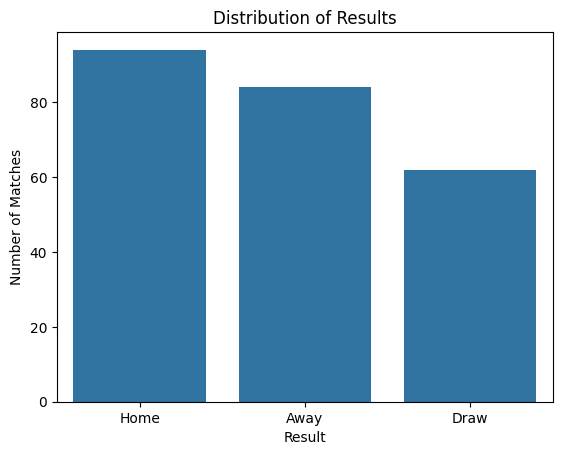

In [91]:
# Count the results
results = matches_finished['Result'].value_counts()

# Visualize
sns.barplot(x=results.index, y=results.values)
plt.title('Distribution of Results')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.show()


Goals x Matchweek

In [ ]:
# Add 'Matchday' column 
if 'matchday' not in matches_data_df.columns:
    matches_data_df['Matchday'] = matches_data_df['season.currentMatchday']
else:
    matches_data_df['Matchday'] = matches_data_df['matchday']


In [ ]:
# Add 'Matchday' to the finished matches DataFrame
matches_finished['Matchday'] = matches_data_df['Matchday']


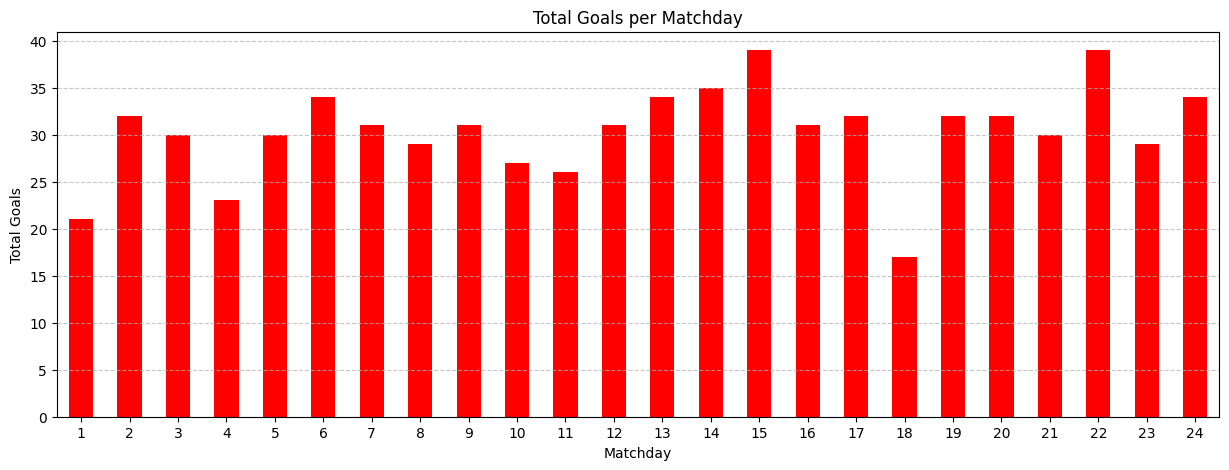

In [95]:
# Group goals by matchday
goals_per_matchday = matches_finished.groupby('Matchday')['Total_Goals'].sum()

# Visualize
plt.figure(figsize=(15, 5))
goals_per_matchday.plot(kind='bar', color='red')
plt.title('Total Goals per Matchday')
plt.xlabel('Matchday')
plt.ylabel('Total Goals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()


Top goal-scoring teams

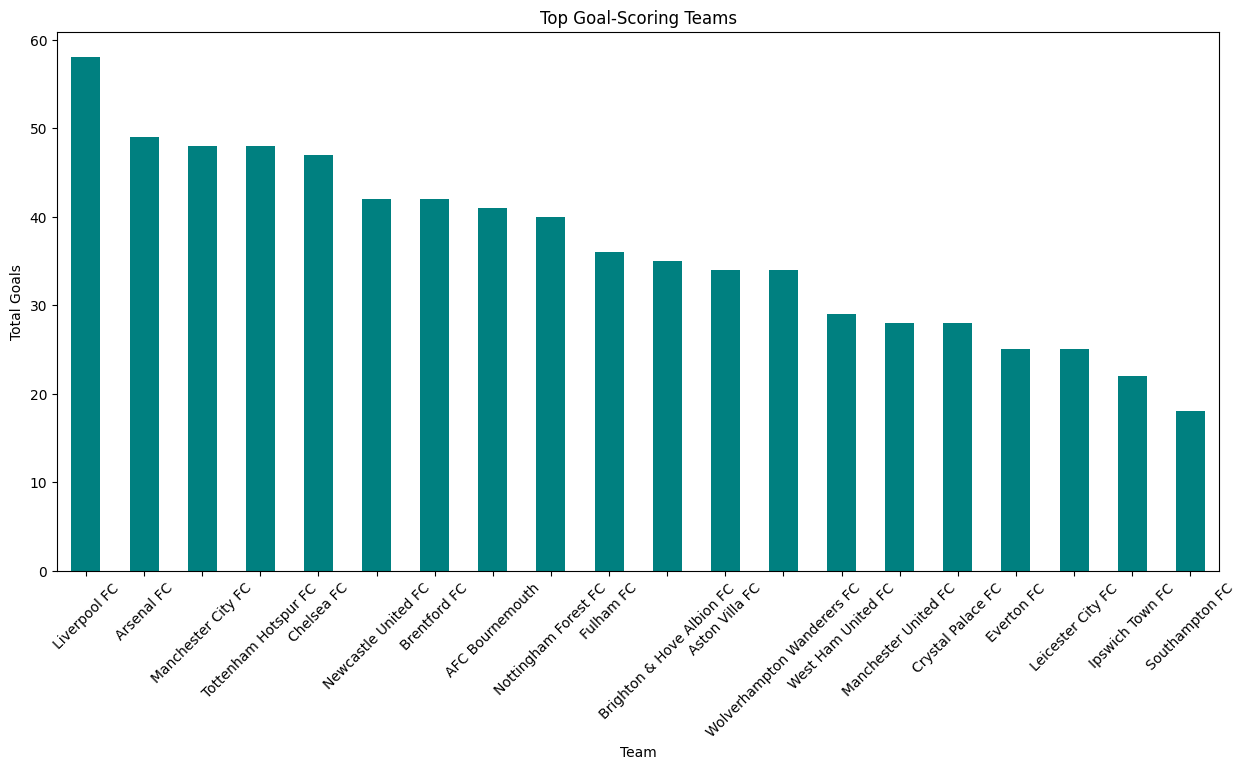

In [96]:
# Goals as Home and Away teams
home_goals = matches_finished.groupby('Home_Team')['Home_Score'].sum()
away_goals = matches_finished.groupby('Away_Team')['Away_Score'].sum()

# Sum both home and away goals
total_goals = home_goals.add(away_goals, fill_value=0).sort_values(ascending=False)

# Visualize
plt.figure(figsize=(15, 7))
total_goals.plot(kind='bar', color='teal')
plt.title('Top Goal-Scoring Teams')
plt.xlabel('Team')
plt.ylabel('Total Goals')
plt.xticks(rotation=45)
plt.show()


Average goals per match

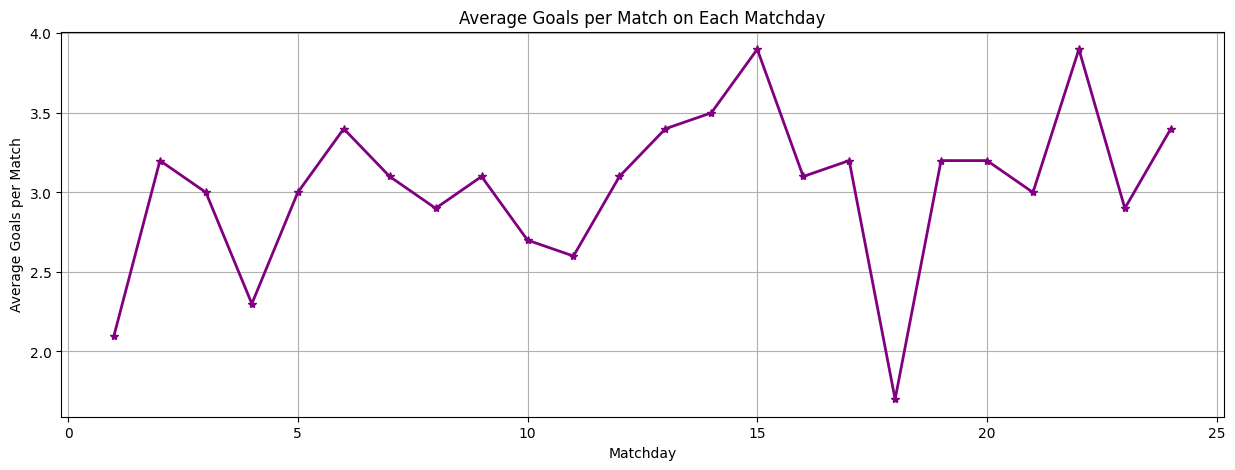

In [97]:
# Calculate the average goals per match on each matchday
average_goals_per_matchday = matches_finished.groupby('Matchday')['Total_Goals'].mean()

# Visualize
plt.figure(figsize=(15, 5))
average_goals_per_matchday.plot(kind='line', marker='*', color='purple', linestyle='-', linewidth=2)
plt.title('Average Goals per Match on Each Matchday')
plt.xlabel('Matchday')
plt.ylabel('Average Goals per Match')
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


Let's see if there is a significant advantage for the home teams:

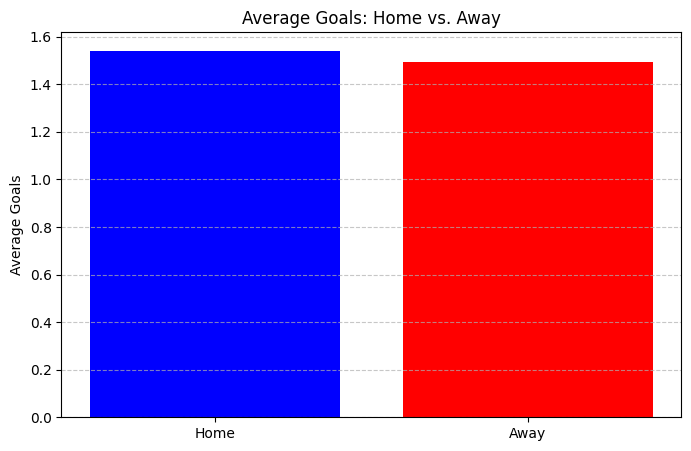

In [98]:
# Calculate the average goals for home and away teams
average_home_goals = matches_finished['Home_Score'].mean()
average_away_goals = matches_finished['Away_Score'].mean()

# Visualize
plt.figure(figsize=(8, 5))
plt.bar(['Home', 'Away'], [average_home_goals, average_away_goals], color=['blue', 'red'])
plt.title('Average Goals: Home vs. Away')
plt.ylabel('Average Goals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Distribution of Results (Home, Draw, Away)

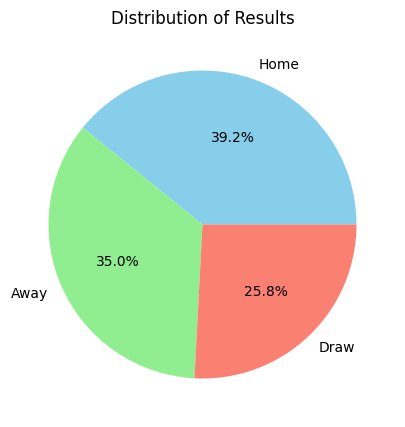

In [99]:
# Count the distribution of results (normalize to percentage)
result_distribution = matches_finished['Result'].value_counts(normalize=True) * 100

# Visualize
plt.figure(figsize=(8, 5))
result_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Results')
plt.ylabel('')
plt.show()


Highest scoring teams (sum of home and away goals).
Teams with the best defense (fewer goals conceded)

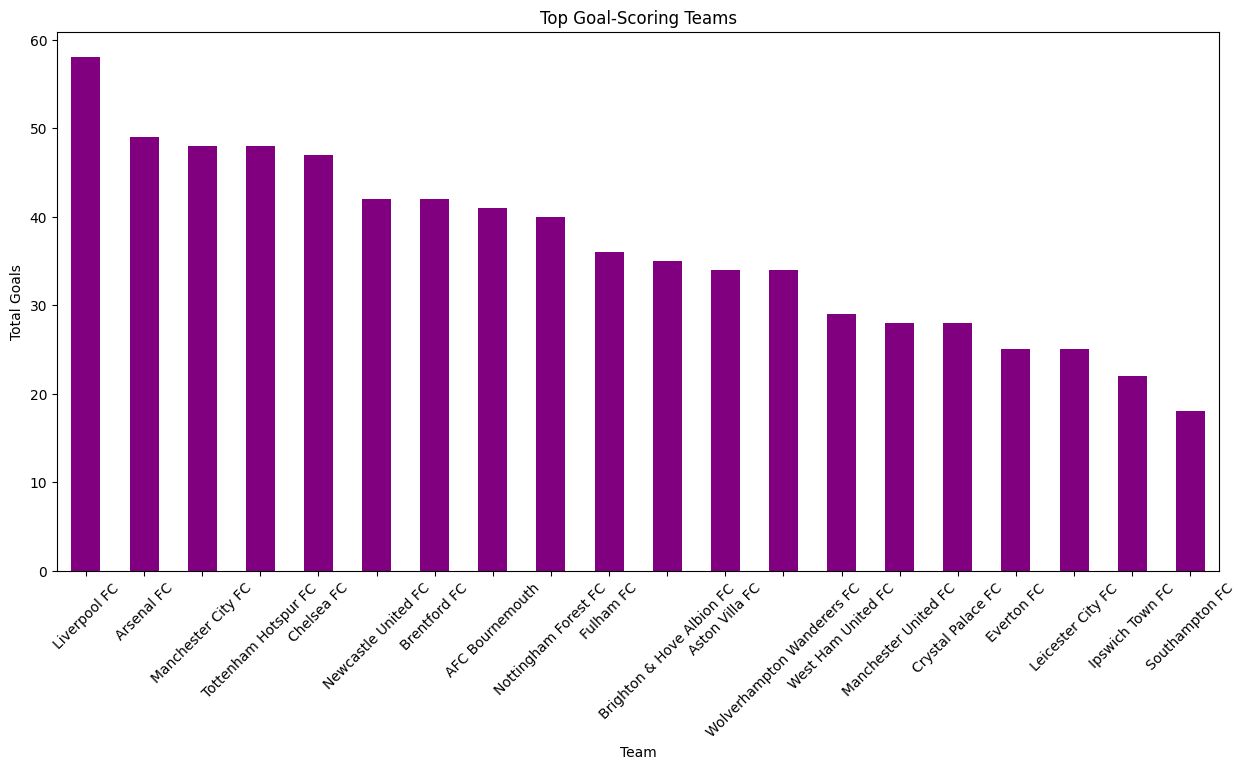

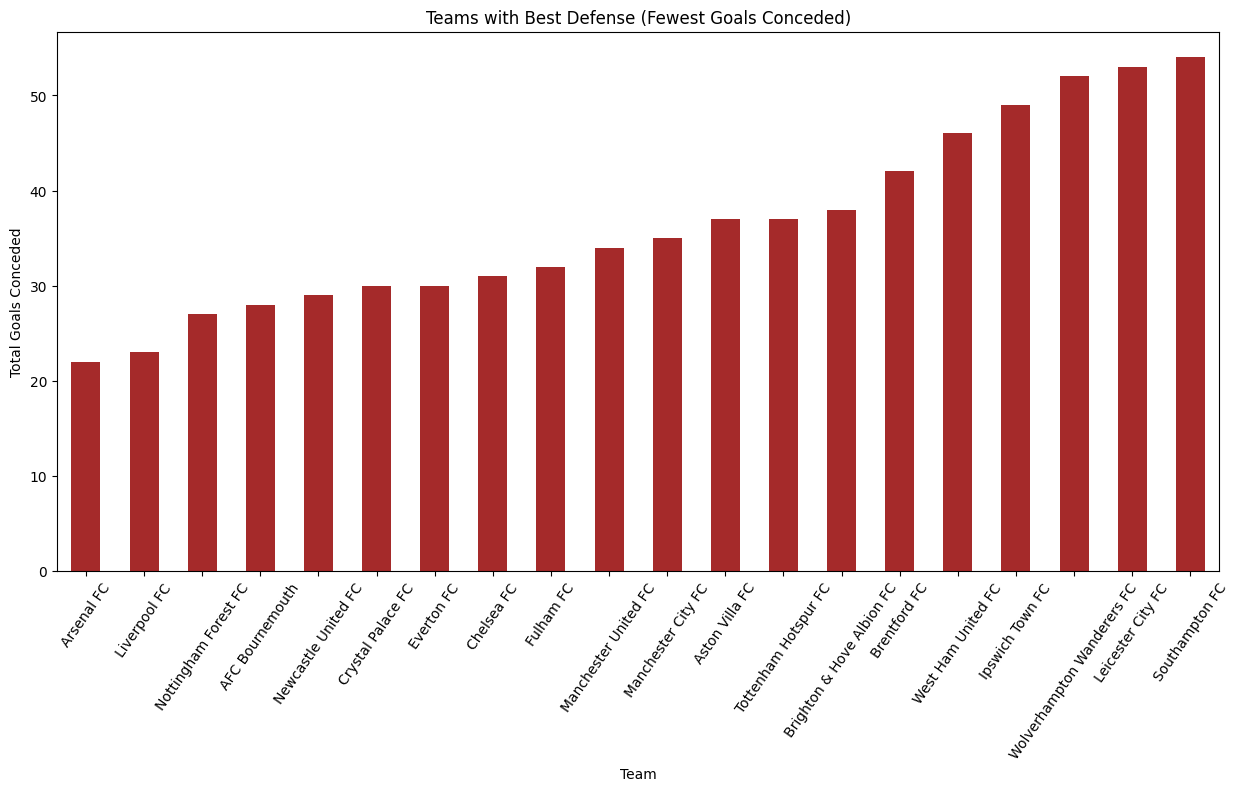

In [103]:
# Goals scored as Home and Away teams
home_goals = matches_finished.groupby('Home_Team')['Home_Score'].sum()
away_goals = matches_finished.groupby('Away_Team')['Away_Score'].sum()

# Sum both home and away goals for total goals
total_goals = home_goals.add(away_goals, fill_value=0).sort_values(ascending=False)

# Goals conceded (best defense)
home_goals_conceded = matches_finished.groupby('Home_Team')['Away_Score'].sum()
away_goals_conceded = matches_finished.groupby('Away_Team')['Home_Score'].sum()

# Sum both home and away goals conceded for total goals conceded
total_goals_conceded = home_goals_conceded.add(away_goals_conceded, fill_value=0).sort_values()

# Visualize Top Scorers
plt.figure(figsize=(15, 7))
total_goals.plot(kind='bar', color='purple')
plt.title('Top Goal-Scoring Teams')
plt.xlabel('Team')
plt.ylabel('Total Goals')
plt.xticks(rotation=45)
plt.show()

# Visualize Best Defense (Fewest Goals Conceded)
plt.figure(figsize=(15, 7))
total_goals_conceded.plot(kind='bar', color='brown')
plt.title('Teams with Best Defense (Fewest Goals Conceded)')
plt.xlabel('Team')
plt.ylabel('Total Goals Conceded')
plt.xticks(rotation=55)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (match result)
le = LabelEncoder()
matches_finished['Encoded_Result'] = le.fit_transform(matches_finished['Result'])


# Feature selection (using home and away goals)
X = matches_finished[['Home_Score', 'Away_Score']]
y = matches_finished['Encoded_Result']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Classifier 

In [110]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)


We calculate the averages of goals scored and conceded by each team in their last matches:

In [ ]:
# Calculate the average home and away scores
avg_home_score = matches_finished.groupby('Home_Team')['Home_Score'].mean()
avg_away_score = matches_finished.groupby('Away_Team')['Away_Score'].mean()

# Calculate the average goals conceded at home and away
avg_conceded_home = matches_finished.groupby('Home_Team')['Away_Score'].mean()
avg_conceded_away = matches_finished.groupby('Away_Team')['Home_Score'].mean()

# Add all the averages to the DataFrame
matches_finished['Avg_Home_Score'] = matches_finished['Home_Team'].map(avg_home_score)
matches_finished['Avg_Away_Score'] = matches_finished['Away_Team'].map(avg_away_score)
matches_finished['Avg_Conceded_Home'] = matches_finished['Home_Team'].map(avg_conceded_home)
matches_finished['Avg_Conceded_Away'] = matches_finished['Away_Team'].map(avg_conceded_away)


Let's use Poisson Regression to predict home and away team goals separately:

Home_Score using characteristics of the home and away team.
Away_Score in the same way.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor

# Select features and targets
features = ['Avg_Home_Score', 'Avg_Away_Score', 'Avg_Conceded_Home', 'Avg_Conceded_Away']

X = matches_finished[features]
y_home = matches_finished['Home_Score']
y_away = matches_finished['Away_Score']

# Split data into training and test sets
X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
X_train, X_test, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

# Create and train model for Home Goals
home_model = PoissonRegressor(alpha=0.1)
home_model.fit(X_train, y_train_home)
pred_home = home_model.predict(X_test)

# Create and train model for Away Goals
away_model = PoissonRegressor(alpha=0.1)
away_model.fit(X_train, y_train_away)
pred_away = away_model.predict(X_test)


We will compare the predictions with the actual values in a scatter plot:

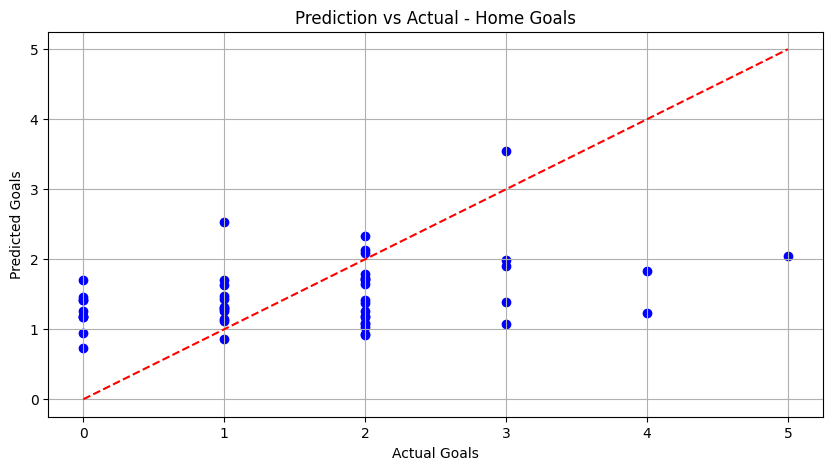

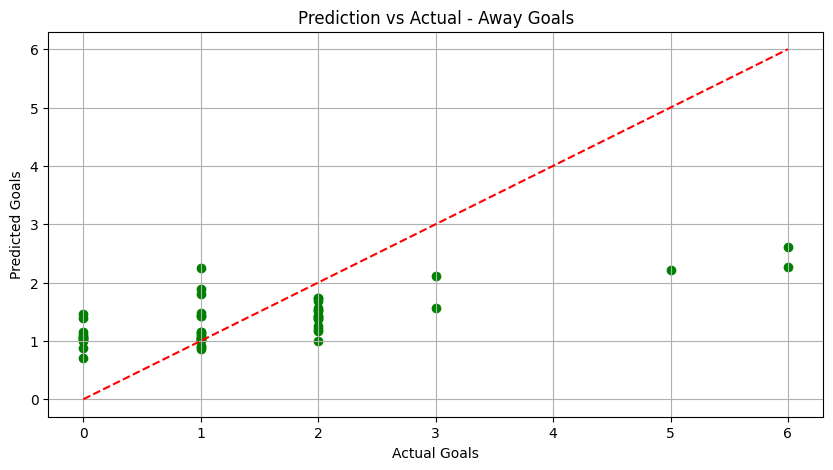

In [113]:
import matplotlib.pyplot as plt

# Visualization for Home Goals
plt.figure(figsize=(10,5))
plt.scatter(y_test_home, pred_home, color='blue')
plt.plot([0, max(y_test_home)], [0, max(y_test_home)], color='red', linestyle='--')
plt.title('Prediction vs Actual - Home Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.grid(True)
plt.show()

# Visualization for Away Goals
plt.figure(figsize=(10,5))
plt.scatter(y_test_away, pred_away, color='green')
plt.plot([0, max(y_test_away)], [0, max(y_test_away)], color='red', linestyle='--')
plt.title('Prediction vs Actual - Away Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.grid(True)
plt.show()


Data Preparation for Matchday 25
First we need to get the data for Matchday 25 using the API. Make sure you have configured it correctly.
We are going to extract the matches of Matchday 25 and prepare the necessary features for the predictions:

In [ ]:
# Get matches for matchday 25
url_matchday25 = 'https://api.football-data.org/v4/competitions/PL/matches?matchday=25'
headers = {'X-Auth-Token': 'xxxxxxxxxxxxxxxxxxxxxxx'}
response = requests.get(url_matchday25, headers=headers)

# Check response
if response.status_code == 200:
    data_matchday25 = response.json()
    matches_matchday25 = pd.json_normalize(data_matchday25['matches'])
else:
    print("Error retrieving data:", response.status_code)

# Select important columns
matches_matchday25 = matches_matchday25[['homeTeam.name', 'awayTeam.name', 'utcDate']]
matches_matchday25.columns = ['Home_Team', 'Away_Team', 'Date']

# Verify data
matches_matchday25.head()


,Home_Team,Away_Team,Date
0,Brighton & Hove Albion FC,Chelsea FC,2025-02-14T20:00:00Z
1,Leicester City FC,Arsenal FC,2025-02-15T12:30:00Z
2,Southampton FC,AFC Bournemouth,2025-02-15T15:00:00Z
3,West Ham United FC,Brentford FC,2025-02-15T15:00:00Z
4,Aston Villa FC,Ipswich Town FC,2025-02-15T15:00:00Z


Let's add the averages of goals scored and goals conceded that we calculated earlier:

In [115]:
# Add goal averages to the Matchday 25 DataFrame
matches_matchday25['Avg_Home_Score'] = matches_matchday25['Home_Team'].map(avg_home_score)
matches_matchday25['Avg_Away_Score'] = matches_matchday25['Away_Team'].map(avg_away_score)
matches_matchday25['Avg_Conceded_Home'] = matches_matchday25['Home_Team'].map(avg_conceded_home)
matches_matchday25['Avg_Conceded_Away'] = matches_matchday25['Away_Team'].map(avg_conceded_away)

# Verify complete data
matches_matchday25.head()


,Home_Team,Away_Team,Date,Avg_Home_Score,Avg_Away_Score,Avg_Conceded_Home,Avg_Conceded_Away
0,Brighton & Hove Albion FC,Chelsea FC,2025-02-14T20:00:00Z,1.272727,2.083333,1.272727,1.333333
1,Leicester City FC,Arsenal FC,2025-02-15T12:30:00Z,0.916667,1.833333,1.750000,1.000000
2,Southampton FC,AFC Bournemouth,2025-02-15T15:00:00Z,0.727273,2.000000,2.727273,1.583333
3,West Ham United FC,Brentford FC,2025-02-15T15:00:00Z,1.333333,1.181818,2.166667,1.545455
4,Aston Villa FC,Ipswich Town FC,2025-02-15T15:00:00Z,1.666667,1.181818,1.166667,2.090909


Next, let's define X_matchday25 with the correct features for prediction:

In [116]:
# Select features for prediction
features = ['Avg_Home_Score', 'Avg_Away_Score', 'Avg_Conceded_Home', 'Avg_Conceded_Away']
X_matchday25 = matches_matchday25[features]

# Check for NaN values
X_matchday25 = X_matchday25.fillna(0)

# Verify dimensions of X_matchday25
print("Dimensions of X_matchday25:", X_matchday25.shape)


Dimensions of X_matchday25: (10, 4)


Let's predict the goals of the home team and the away team in each match:

In [117]:
# Goals predictions
pred_home_goals = home_model.predict(X_matchday25)
pred_away_goals = away_model.predict(X_matchday25)

# Round to the nearest integer
matches_matchday25['Home_Goals_Pred'] = pred_home_goals.round(0).astype(int)
matches_matchday25['Away_Goals_Pred'] = pred_away_goals.round(0).astype(int)

# Show predicted scores
matches_matchday25[['Home_Team', 'Away_Team', 'Home_Goals_Pred', 'Away_Goals_Pred']]


,Home_Team,Away_Team,Home_Goals_Pred,Away_Goals_Pred
0,Brighton & Hove Albion FC,Chelsea FC,1,2
1,Leicester City FC,Arsenal FC,1,2
2,Southampton FC,AFC Bournemouth,1,3
3,West Ham United FC,Brentford FC,1,2
4,Aston Villa FC,Ipswich Town FC,2,1
5,Manchester City FC,Newcastle United FC,2,1
6,Fulham FC,Nottingham Forest FC,1,1
7,Crystal Palace FC,Everton FC,1,1
8,Liverpool FC,Wolverhampton Wanderers FC,3,1
9,Tottenham Hotspur FC,Manchester United FC,2,1


In [118]:
# Create 'Prediction_Result' column with default value based on predicted goals
matches_matchday25['Prediction_Result'] = 'Draw'  # Initial value
matches_matchday25.loc[matches_matchday25['Home_Goals_Pred'] > matches_matchday25['Away_Goals_Pred'], 'Prediction_Result'] = 'Home'
matches_matchday25.loc[matches_matchday25['Home_Goals_Pred'] < matches_matchday25['Away_Goals_Pred'], 'Prediction_Result'] = 'Away'


In [119]:
# Review the results and adjust if necessary
for index, row in matches_matchday25.iterrows():
    if row['Prediction_Result'] == 'Draw':
        # If the goals are not equal in a "Draw", change the result to "Won"
        if row['Home_Goals_Pred'] != row['Away_Goals_Pred']:
            # If the home team has more goals, the result is "Won" for the home team
            if row['Home_Goals_Pred'] > row['Away_Goals_Pred']:
                matches_matchday25.at[index, 'Prediction_Result'] = 'Home'
            # If the away team has more goals, the result is "Won" for the away team
            elif row['Away_Goals_Pred'] > row['Home_Goals_Pred']:
                matches_matchday25.at[index, 'Prediction_Result'] = 'Away'

# Show the adjusted predictions
print(matches_matchday25[['Home_Team', 'Away_Team', 'Prediction_Result', 'Home_Goals_Pred', 'Away_Goals_Pred']])


                   Home_Team                   Away_Team Prediction_Result  \
0  Brighton & Hove Albion FC                  Chelsea FC              Away   
1          Leicester City FC                  Arsenal FC              Away   
2             Southampton FC             AFC Bournemouth              Away   
3         West Ham United FC                Brentford FC              Away   
4             Aston Villa FC             Ipswich Town FC              Home   
5         Manchester City FC         Newcastle United FC              Home   
6                  Fulham FC        Nottingham Forest FC              Draw   
7          Crystal Palace FC                  Everton FC              Draw   
8               Liverpool FC  Wolverhampton Wanderers FC              Home   
9       Tottenham Hotspur FC        Manchester United FC              Home   

   Home_Goals_Pred  Away_Goals_Pred  
0                1                2  
1                1                2  
2                1         

Code to create the DataFrames:

In [ ]:
# Simulate the results (make sure `matches_jornada25` is defined with your data)
df_results = matches_matchday25[['Home_Team', 'Away_Team', 'Prediction_Result', 'Home_Goals_Pred', 'Away_Goals_Pred']]

# Display the table directly in the Jupyter Notebook
# Specify the new order of the columns
new_column_order = ['Home_Team', 'Home_Goals_Pred', 'Away_Goals_Pred', 'Away_Team', 'Prediction_Result']

# Rearrange the columns according to the new order
df_results = df_results[new_column_order]

# Show the table with the new column order
df_results


,Home_Team,Home_Goals_Pred,Away_Goals_Pred,Away_Team,Prediction_Result
0,Brighton & Hove Albion FC,1,2,Chelsea FC,Away
1,Leicester City FC,1,2,Arsenal FC,Away
2,Southampton FC,1,3,AFC Bournemouth,Away
3,West Ham United FC,1,2,Brentford FC,Away
4,Aston Villa FC,2,1,Ipswich Town FC,Home
5,Manchester City FC,2,1,Newcastle United FC,Home
6,Fulham FC,1,1,Nottingham Forest FC,Draw
7,Crystal Palace FC,1,1,Everton FC,Draw
8,Liverpool FC,3,1,Wolverhampton Wanderers FC,Home
9,Tottenham Hotspur FC,2,1,Manchester United FC,Home
